In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import types
import pickle
import rasterio
import obspy
from obspy.signal.cross_correlation import correlate, xcorr_max
from pyproj import Proj,transform,Geod
from scipy.signal import find_peaks,hilbert,butter,filtfilt
from scipy.fft import rfft,rfftfreq
from scipy.integrate import odeint
from seismic_analysis.preprocessing import download_data,remove_ir
from seismic_analysis.visualization import make_spectrogram
from seismic_analysis.attenuation import estimate_Q
from seismic_analysis.location import (compute_backazimuths,get_station_lon_lat,get_station_crs_locations,
                                get_station_grid_locations,load_data,get_grid,get_arrivals,get_velocities,
                                gridsearch,transform_imagery,plot_location)
from seismic_analysis.directivity import get_velocity, get_characteristic_frequency
from modeling.viscoelastic_beam import get_coefficients,asymptotic_solution,decay_comparison_plot
from modeling.fluid_fracture import find_min_rxx,model_fracture

In [ ]:
'''

Display TerraSAR-X data from May 2012 to identify new rift and map fracture extent

'''

In [ ]:
'''

Download seismic data and remove instrumental response

'''

# download data for May 9 event
data_path = "data/"
starttime = obspy.UTCDateTime(2012, 5, 7)
endtime = obspy.UTCDateTime(2012, 5, 12)
networks = ["XC","YT"]
stations = ["PIG*","DNTW","UPTW","THUR","BEAR"]
channels = ["HH","BH"]
download_data(data_path,starttime,endtime,networks,stations,channels)

# dowload data for Scotia Sea earthquake
starttime = obspy.UTCDateTime(2013, 11, 17)
endtime = obspy.UTCDateTime(2013, 11, 18)
download_data(data_path,starttime,endtime,["XC"],["PIG2"],["HH"])

# remove instrumental response from data
output_type = 'VEL'
HH_freq_lims = [0.00005,0.0001,45,50]
BH_freq_lims = [0.00005,0.0001,15,20]
remove_ir(data_path,"HH",HH_freq_lims,output_type)
remove_ir(data_path,"BH",BH_freq_lims,output_type)

In [ ]:
'''

Plot time period between TerraSAR-X images

'''


In [ ]:
'''

Make spectrograms of May 9 event

'''

# read data
station = "PIG2"
channels = ["HHZ","HHN","HHE"]

# set parameters for spectrogram
starttime = obspy.UTCDateTime(2012,5,9,17,30)
endtime = obspy.UTCDateTime(2012,5,9,22)
low_freq = 0.0005
window_length = 50000
n_overlap = 20000

# make spectrogram of event
for channel in channels:
    st = obspy.read("data/MSEED/no_IR/" + station + "/" + channel + "/" + "2012-05-09*")
    make_spectrogram(st,starttime,endtime,low_freq,window_length,n_overlap)

In [ ]:
''' 

Compare spectra of May 9 event and Scotia plate teleseismic signal

'''

# set windows for both events and noise window before each event
rift_event_win = [obspy.UTCDateTime(2012, 5, 9, 18), obspy.UTCDateTime(2012, 5, 9, 19)]
rift_noise_win = [obspy.UTCDateTime(2012, 5, 9, 15), obspy.UTCDateTime(2012, 5, 9, 16)]
scotia_event_win = [obspy.UTCDateTime(2013, 11, 17, 9), obspy.UTCDateTime(2013, 11, 17, 10)]
scotia_noise_win = [obspy.UTCDateTime(2013, 11, 17, 8), obspy.UTCDateTime(2013, 11, 17, 9)]

In [ ]:
'''

Use BedMachine and David Shean's 2012 DEM of PIG to compute average ice and water thicknesses

'''

In [ ]:
'''

Measure e-folding time and Q value from observations

'''

# set station and channel
station = "PIG2"
channel = "HHZ"

# read and process seismic data
st = obspy.read("data/MSEED/no_IR/" + station + "/" + channel + "/2012-05-09." + station + "." + channel + ".no_IR" + ".MSEED")

# set frequency bands (below values are log space)
#bands = [-3,-2.8,-1,0,1,2]
nyquist = np.log10(st[0].stats.sampling_rate/2)
freq_low = -3
num_steps = 35
step_size = (nyquist-freq_low)/num_steps
bands = [-3 + step_size*i for i in range(num_steps)]
if np.sum([bands == 0]) > 0: bands.remove(0)

# estimate Q in each frequency band
Q_vect = []
T_vect = []
for i in range(len(bands)-1):
    # estimate Q for current frequency band
    band = [10**bands[i],10**bands[i+1]]
    starttime = obspy.UTCDateTime(2012, 5, 9, 18)
    endtime = obspy.UTCDateTime(2012, 5, 9, 19,30)
    T,Q = estimate_Q(st.copy(),band,[starttime,endtime])
    Q_vect = np.append(Q_vect,Q)
    T_vect = np.append(T_vect,T)

In [ ]:
'''

Model viscoelastic beam to see whether viscous damping can explain observed ringdown time 

'''

# set ice shelf geometry (length is used to set lowest wavenumber)
H_i = 550
H_w = 700
L = 7e4

# define a range of wavenumbers
xi_vect = np.logspace(-5,np.log10(1000/H_i),100)

# define material properties
eta = 4e12
E = 8.7e9
nu = 0.3
mu = E/2/(1+nu)
t_m = eta/mu

# choose which physics to include
flexure = 1
water_waves = 1
inertia = 1
buoyancy = 1
physics = [flexure,water_waves,inertia,buoyancy]

# iterate through wavenumber vector and find roots
roots = []
for xi in xi_vect:
    coefficients = get_coefficients(H_i,H_w,xi/2/np.pi,eta,physics)
    roots.append(np.roots(coefficients))
roots = np.array(roots)

# get Taylor series approximations of the analytical expression for Q 
approximate_solutions = []
for xi in xi_vect:
    approximate_solutions.append(asymptotic_solution(xi,H_i,H_w,eta))
approximate_solutions = np.array(approximate_solutions)

# make plot comparing numerical Q and asymptotic approximation to Q
period_of_interest = 500
decay_comparison_plot(xi_vect,roots,approximate_solutions[:,3],T_vect,Q_vect,eta,E,period_of_interest)

In [2]:
'''

Determine backazimuth of the event using polarization directions at local stations

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 50
l.slide = 5
l.trace_len = 8*60
l.num_steps = int((l.trace_len-l.win_len)/l.slide)+1
l.stations = ["PIG2","PIG4","PIG5"]
l.network = ["XC"]

# specify path to data, XML, and output
l.data_path = "data/MSEED/no_IR"
l.xml_path = "data/XML"
l.filename = "outputs/locations/" + "_".join(l.stations) + "_backazimuth"
l.n_procs = 10

# set event start time
event_start = datetime.datetime(2012, 5, 9, 18, 1)
event_end = event_start + datetime.timedelta(seconds=l.trace_len)
l.detection_times = np.array([event_start])

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations and sta/lta ratio for throwing out individual windows in backazimuth computation
l.snr_threshold = 0
l.stalta_threshold = 0

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000

# set frequency band for backazimuth calculation
l.fs = 100
l.freq = [1.5,5]

# calculate backazimuth for the event
b = compute_backazimuths(l)

Got all files...

Made inputs...

Finished with 2012-05-09



In [14]:
'''

Locate the event using travel time inversion of arrivals at regional stations

'''

# Notes
# 1. What frequency band is used for arrival estimation?
# 2. Which stations are included?
# 3. Are arrival times estimated using data or envelope of data?
# 5. What weights are used, if any?
#     A. Cross correlation coefficient
#.    B. Travel time residuals
#.    C. Weight each station based on the variance of residuals of each component at that station
# 6. What phase velocity is used? Is it the same for local and regional stations? Is it the same for each component?
# 7. Which components are included?
#     A. Each station's arrival time residual is the average of the residuals of each component at that station
#     B. Each component is treated like a separate observation then summed 
 
# read data
st = obspy.read("data/MSEED/no_IR/*/*/2012-05-09*")

# set frequency band for analysis
freq = [1.5,5]

# choose component to use for location
channels = ["Z","N","E"]

# set starttime and endtime for analysis
starttime=obspy.UTCDateTime(2012,5,9,18,1)
endtime=obspy.UTCDateTime(2012,5,9,18,9)

# select, filter, and trim regional data
regional_stations = ["THUR","DNTW","BEAR","UPTW"]
st_regional = obspy.Stream()
for stat in regional_stations:
    for channel in channels: 
        st_regional = st_regional.append(st.select(station=stat,component=channel)[0])
st_regional.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
st_regional.trim(starttime=starttime,endtime=endtime)

# select, filter, and trim local stations
local_stations = ["PIG2","PIG4","PIG5"]
st_local = obspy.Stream()
for station in local_stations:
    for channel in channels:
        st_local += st.select(station=station,component=channel)
st_local.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
st_local.trim(starttime=starttime,endtime=endtime)
st_local.resample(st_regional[0].stats.sampling_rate)

# estimate phase velocity of waves traveling from local reference station to each regional station (note that
# this assumes local station is close to the event location)
local_velocity = 1500
velocities = []
for station in local_stations:
    velocities.append(list(np.ones(len(channels))*local_velocity))
for station in regional_stations:
    station_velocities = []
    for channel in channels:
        tr_local = st_local.select(station="PIG2",component=channel)[0]
        tr_regional = st_regional.select(station=station,component=channel)[0]
        station_velocities.append(get_velocity(tr_local,tr_regional))
    velocities.append(station_velocities)

# combine into one stream and remove any stations, if desired
stations = local_stations + regional_stations
st = st_local + st_regional



def get_arrival(tr_ref,tr,method=""):
# iterate through regional stations

    max_shift = len(tr_ref)*2
    local_env = obspy.Trace(np.abs(hilbert(tr_ref.data)))

    # cross correlate envelope with envelope of data from local station 
    if method == "envelope":
        env = obspy.Trace(np.abs(hilbert(tr.data)))
        cc = correlate(env,local_env,max_shift)
    else:
        cc = correlate(tr,tr_ref,max_shift)
    shift,xcorr_coef = xcorr_max(cc)
    arrival = shift/tr.stats.sampling_rate
    return arrival, xcorr_coef



def get_station_lat_lon(st):
    channel = st[0].stats.component
    st = st.select(component=channel)
    coordinates = []
    for tr in st:
        inv = obspy.read_inventory("data/XML/*"+tr.stats.station+"*")
        trace_id = tr.stats.network + "." + tr.stats.station + ".." + tr.stats.channel.split('H' + channel)[0] + "H" + channel
        coordinates.append([inv.get_coordinates(trace_id)["latitude"],inv.get_coordinates(trace_id)["longitude"]])
    return coordinates


# get arrival times relative to PIG2
arrivals = []
xcorr_coefs = []
for station in stations:
    station_arrivals = []
    station_xcorr_coef = []
    for channel in channels:
        tr_ref = st_local.select(station="PIG2",component=channel)[0]
        tr = st.select(station=station,component=channel)[0]
        arrival, xcorr_coef = get_arrival(tr_ref,tr,"envelope")
        station_arrivals.append(arrival)
        station_xcorr_coef.append(xcorr_coef)
    arrivals.append(station_arrivals)
    xcorr_coefs.append(station_xcorr_coef)
    
# use the absolute value of cross correlation coefficients to weight arrivals
weights = np.abs(xcorr_coefs)

# get station latitude and longitude
station_lat_lon = get_station_locations(st)

# define grid origin in lat,lon and grid dimensions in meters
origin_lat = -75.5
origin_lon = -103.2
grid_length = 1.5e5
grid_height = 1.3e5
step = 100000
t0 = -10
t_step = 0.1

# get station locations on grid
station_x_y = []
for i in range(len(station_lat_lon)):
    x_dist = distance.distance([origin_lat,origin_lon],[origin_lat,station_lat_lon[i][1]]).m
    if station_lat_lon[i][1] < origin_lon:
        x_dist = -x_dist
    y_dist = distance.distance([origin_lat,origin_lon],[station_lat_lon[i][0],origin_lon]).m
    if station_lat_lon[i][0] < origin_lat:
        y_dist = -y_dist
    station_x_y.append([x_dist,y_dist])
station_x_y = np.array(station_x_y)

# set grid points
x_vect = np.arange(0, grid_length, step)
y_vect = np.arange(0, grid_height, step)
t_vect = np.arange(t0,0,t_step)


# carry out the gridsearch
rmse_mat = gridsearch(t_vect,x_vect,y_vect,station_x_y,velocities,arrivals)

# find lowest error lat, lon, and origin time
loc_idx = np.unravel_index(np.argmin(rmse_mat), rmse_mat.shape)
rmse_loc = rmse_mat[loc_idx[0],:,:]


In [19]:
arrivals

[[0.0, 0.0, 0.0],
 [1.45, 2.8500000000000001, 1.075],
 [-3.5249999999999999, -6.0750000000000002, -7.5],
 [66.637500000000003, 76.9375, 72.887500000000003],
 [48.962499999999999, 63.037500000000001, 66.012500000000003],
 [45.237499999999997, 54.712499999999999, 76.637500000000003],
 [34.5625, 82.512500000000003, 78.537499999999994]]

/home/solinger/miniconda3/envs/sermeq_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/solinger/notebooks/olinger_et_al_2022B/seismic_analysis/location.py:865: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


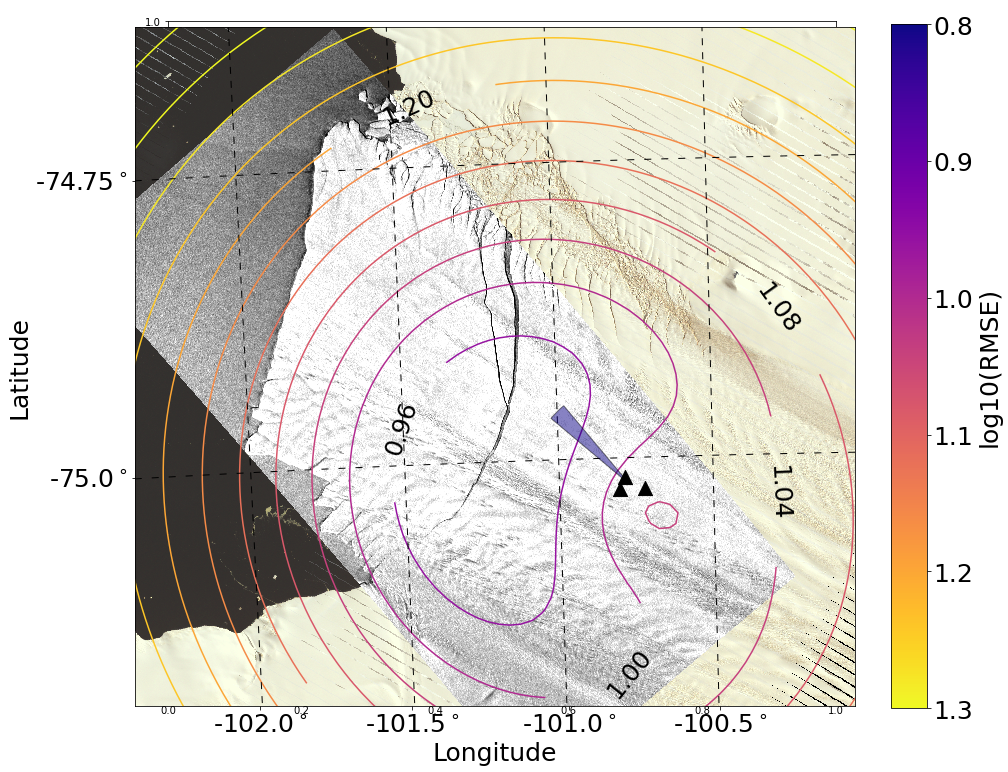

In [5]:
'''

Plot the backazimuthal and gridsearch locations on imagery

'''

# load landsat images
landsat_scenes  = ['LE07_L2SR_233113_20120128_20200909_02_T2','LE07_L2SR_001113_20120204_20200909_02_T2']

# transform imagery into convenient coordinate system EPSG:3245
for landsat_scene in landsat_scenes:
    file_path = 'data/LANDSAT/'+landsat_scene+'/'+landsat_scene + "_SR"
    transform_imagery(file_path+'_B2.TIF','epsg:3245')
    transform_imagery(file_path+'_B3.TIF','epsg:3245')
    transform_imagery(file_path+'_B4.TIF','epsg:3245')

# set TerraSAR-X data file path
tsx_scene = 'data/TSX/dims_op_oc_dfd2_689344819_5/TSX-1.SAR.L1B/TDX1_SAR__MGD_SE___SM_S_SRA_20120511T031339_20120511T031349/IMAGEDATA/IMAGE_HH_SRA_strip_003.tif'
    
# load the results of polarization analysis
baz_file = open('outputs/locations/PIG2_PIG4_PIG5_backazimuth.pickle', "rb")
b = pickle.load(baz_file)
backazimuth = b.backazimuths
baz_file.close()

# load the results of polarization analysis
grid_file = open('outputs/locations/PIG2_PIG4_PIG5_THUR_DNTW_BEAR_UPTW_gridsearch.pickle', "rb")
rmse_mat = pickle.load(grid_file)
grid_file.close()
loc_idx = np.unravel_index(np.argmin(rmse_mat), rmse_mat.shape)
rmse_loc = rmse_mat[loc_idx[0],:,:]

# get local station locations and array centroids
station_lon_lat_coords = get_station_lon_lat("data/XML/",["XC"],["PIG2","PIG4","PIG5"])
station_grid_coords = get_station_crs_locations(station_lon_lat_coords,"epsg:3245")

# get gridsearch axes
origin_lat = -75.5
origin_lon = -103.2
grid_length = 1.5e5
grid_height = 1.3e5
step = 1000
x_vect = np.arange(0, grid_length, step)
y_vect = np.arange(0, grid_height, step)
p2 = Proj("EPSG:3245",preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
origin_x,origin_y = transform(p1,p2,origin_lon,origin_lat)
grid_axes_coords = [origin_x + x_vect, origin_y + y_vect]

# make plot of location
plot_location(landsat_scenes,tsx_scene,backazimuth,rmse_loc,station_grid_coords,grid_axes_coords)

# Relating rupture speed to Doppler shift at two stations

\begin{align}
\text{In front of rift:} \hspace{0.5cm} f_{front} = f_f = \frac{c + v_o}{c - v_s} f\\
\text{Behind rift:} \hspace{0.5cm} f_{behind} = f_b = \frac{c + v_o}{c + v_s} f\\
\text{Observer velocity is zero:} \hspace{0.5cm} f_f = \frac{c}{c-v_s}f \hspace{0.5cm} \text{and} \hspace{0.5cm} f_b = \frac{c}{c+v_s}f\\
\frac{f_f}{f_b} = \left(\frac{c}{c-v_s}f\right) \div \left(\frac{c}{c+v_s}f\right)\\
\frac{f_f}{f_b} = \frac{c+v_s}{c-v_s}\\
f_f(c-v_s) = f_b(c+v_s)\\
f_fv-f_fv_s = f_bv+f_bv_s\\
f_fv - f_bv = f_fv_s+f_bv_s\\
c(f_f - f_b) = v_s(f_b+f_f)\\
v_s = c\frac{f_f-f_b}{f_f + f_b}\\
\end{align}

In [ ]:
'''

Estimate rift tip velocity using Doppler shift between DNTW and THUR

'''

# read data
st = obspy.read("data/MSEED/no_IR/*/*/2012-05-09*")

# set frequency band for analysis
freq = [1,5]

# set starttime and endtime for analysis
starttime=obspy.UTCDateTime(2012,5,9,18,2)
endtime=obspy.UTCDateTime(2012,5,9,18,8)

# select, filter, and trim regional data
regional_stations = ["DNTW","THUR"]
st_regional = obspy.Stream()
for stat in regional_stations:
    st_regional = st_regional.append(st.select(station=stat,channel="BHZ")[0])
st_regional.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
st_regional.trim(starttime=starttime,endtime=endtime)

# select, filter, and trim local data
local_stations = "PIG2"
st_local = st.select(station=local_stations,channel="HHZ")
st_local.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
st_local.trim(starttime=starttime,endtime=endtime)
st_local.resample(st_regional[0].stats.sampling_rate)
tr_local = st_local[0]

# estimate phase velocity of waves traveling from local to regional stations
velocities = []
for tr_regional in st_regional:
    velocities.append(get_velocity(tr_local,tr_regional))
mean_velocity = np.mean(velocities)

# get characteristic frequencies at each regional station
data_f = st.select(station="DNTW",channel="BHZ")[0].data
data_b = st.select(station="THUR",channel="BHZ")[0].data
f_f = get_characteristic_frequency(data_f,st[0].stats.sampling_rate,freq,"fft","median")
f_b = get_characteristic_frequency(data_b,st[0].stats.sampling_rate,freq,"fft","median")

# calculate rupture speed
v_s = (f_f-f_b)/(f_b+f_f)*mean_velocity

# estimate event duration
length = 7000
duration = length/v_s

# print results
print("Estimated rupture velocity: " + str(v_s) + " m/s")
print("Estimated duration: " + str(duration) + " s")

In [ ]:
'''

Model coupled fluid-fracture system to test whether fluid processes can explain slow rift tip velocity 

'''

H_i = 200
rho_i = 910
rho_w = 1000
H_w = rho_i/rho_w * H_i
g = 9.8
eta0 = H_w
d_eta_dt0 = 0
L0 = 5e3
w0 = 2
K_ic = 1e5
sigma0 = -rho_i*g*H_i/2 + rho_w*g/(2*H_i)*eta0**2
epsilon = 40

# The following calculates Rxx such that K_ic = K_i, and then adds a tiny perturbation
Rxx = find_min_rxx(L0,sigma0,K_ic)[0]+1

# run simulations
y0 = [eta0, d_eta_dt0,L0]
t = np.linspace(0, 400, 10001)
fig,ax=plt.subplots(3,1,figsize=(10,10),dpi=100)
fig.patch.set_facecolor('w')
sol = odeint(model_fracture, y0, t, args=(epsilon, H_i, Rxx, w0))

# plot solution
ax[0].plot(t, sol[:, 0]-H_w)
ax[0].set_ylabel('Deflection of water surface (m)')
ax[1].plot(t, np.gradient(sol[:, 2],t), label='L(t), km')
ax[1].set_ylabel('Crack propagation rate (m/s)')
ax[2].plot(t, sol[:, 2]/1e3, label='L(t), km')
ax[2].set_ylabel('Crack length (km)')
print("Mean crack propagation rate (epsilon="+str(epsilon)+"):",np.round(np.mean(np.gradient(sol[:, 2],t)),2)," m/s")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.xlabel('Time (seconds)')
plt.show()

In [ ]:
import cv2
from skimage.measure import block_reduce

landsat_scene  = 'LE07_L2SR_001113_20120204_20200909_02_T2'
landsat_B2 = rasterio.open('data/LANDSAT/'+landsat_scene+'/'+landsat_scene+'_SR_B2_epsg:3245.TIF') #blue
landsat_B3 = rasterio.open('data/LANDSAT/'+landsat_scene+'/'+landsat_scene+'_SR_B3_epsg:3245.TIF') #green
landsat_B4 = rasterio.open('data/LANDSAT/'+landsat_scene+'/'+landsat_scene+'_SR_B4_epsg:3245.TIF') #red
image_B2 = landsat_B2.read(1)
image_B3 = landsat_B3.read(1)
image_B4 = landsat_B4.read(1)

# crop each band to 99th percentile of brightness
image_B2[image_B2 > np.percentile(image_B2,99)] = np.percentile(image_B2,99)
image_B3[image_B3 > np.percentile(image_B3,99)] = np.percentile(image_B3,99)
image_B4[image_B4 > np.percentile(image_B4,99)] = np.percentile(image_B4,99)

# combine bands into natural color image
image_rgb = np.array([image_B2, image_B3, image_B4]).transpose(1,2,0)
normalized_rgb = (image_rgb * (255 / np.max(image_rgb)))

# downsample image
downsampled_rgb = block_reduce(normalized_rgb, block_size=10)[:,:,0].astype(np.uint16)

mask = np.zeros(downsampled_rgb.shape[:2]).astype(np.uint8)
mask[np.nonzero(downsampled_rgb == 0)] = 1

test = cv2.inpaint(downsampled_rgb,mask,3,cv2.INPAINT_TELEA)

fig,ax = plt.subplots(figsize=(15,15))

ax.imshow(test)
plt.show()



from skimage.restoration import inpaint

landsat_scene  = 'LE07_L2SR_001113_20120204_20200909_02_T2'
landsat_B2 = rasterio.open('data/LANDSAT/'+landsat_scene+'/'+landsat_scene+'_SR_B2_epsg:3245.TIF') 
image_B2 = landsat_B2.read(1)

mask_B2 = np.copy(image_B2)
mask_B2[np.nonzero(mask_B2)] = 1

test = inpaint.inpaint_biharmonic(image_B2, mask_B2)

fig,ax = plt.subplots(figsize=(15,15))

ax.imshow(test)
plt.show()